In [27]:
# Building chatbot with multiple tools- arxiv,wikipedia search,tavily search and custom functions like add,multiply using Langgraph

import os
from dotenv import load_dotenv
load_dotenv()

# open source model from groq
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
api_key = os.getenv("GROQ_API_KEY")
# LLM with function call
llm=ChatGroq(groq_api_key=api_key,model_name="llama-3.1-8b-instant")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
# Set environment variables for LangSmith tracking and LangChain project
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGRAPH_LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [28]:
from pydantic import BaseModel
from typing import Annotated # we can see all messages in conversation in form of list
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages # reducer to add messages to state
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint # pretty print
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [29]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
## Working With Tools
## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

#wiki_tool.invoke("who is Sharukh Khan")
#arxiv_tool.invoke("Attention is all you need")

## tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool =TavilySearchResults()
#tavily_tool.invoke("Provide me recent AI news for 16th october 2025")

In [30]:
# Tool use with function calling and docstrings
# custom functions

def add(a: int, b: int) -> int:
    """ 
    Add a and b 
    Args: 
        a: first integer
        b: second integer 
    returns:
        integer result
    """
    result = a + b
    return result


def multiply(a: float, b: float) -> float:
    """ 
    Multiply a and b 
    Args: 
        a: first float
        b: second float 
    returns:
        float result
    """
    result = a * b
    return result

def Divide(a: float, b: float) -> float:
    """ 
    Divide a and b 
    Args: 
        a: first float
        b: non zero second float 
    returns:
        float result
    """
    result = a / b
    return result

def tavily_search(query: str) -> str:
    """
    Search the Tavily knowledge base for relevant information.
    Args:
        query: The search query string.
    Returns:
        A string containing the search results.
    """
    results = tavily_tool.invoke(query)
    return f"Tavily search results for '{query}': {results}"

def arxiv_search(query: str) -> str:
    """
    Search the Arxiv knowledge base for relevant research paper information.
    Args:
        query: The search query string.
    Returns:
        A string containing the search results.
    """
    results = arxiv_tool.invoke(query)
    return f"Arxiv search results for '{query}': {results}"

def wiki_search(query: str) -> str:
    """
    Search the Wikipedia knowledge base for relevant wikipedia information.
    Args:
        query: The search query string.
    Returns:
        A string containing the search results.
    """
    results = wiki_tool.invoke(query)
    return f"Wikipedia search results for '{query}': {results}"

# we can add rag custom tool too and anyother tools

In [31]:
from langchain.tools import StructuredTool

# wrap each of your custom functions
add_tool = StructuredTool.from_function(add)
multiply_tool = StructuredTool.from_function(multiply)
divide_tool = StructuredTool.from_function(Divide)
tavily_tool_wrapped = StructuredTool.from_function(tavily_search)
arxiv_tool_wrapped = StructuredTool.from_function(arxiv_search)
wiki_tool_wrapped = StructuredTool.from_function(wiki_search)

tools = [add_tool, multiply_tool, divide_tool, tavily_tool_wrapped, arxiv_tool_wrapped, wiki_tool_wrapped]

In [32]:
#tools=[wiki_search,arxiv_search,add,multiply,tavily_search]

# binding tool with llm
llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools.invoke([HumanMessage(content="What is recent AI news as on 16th october 2025?")]).tool_calls

[{'name': 'arxiv_search',
  'args': {'query': 'AI news 16th October 2025'},
  'id': '59hm3ajqa',
  'type': 'tool_call'},
 {'name': 'tavily_search',
  'args': {'query': 'AI news 16th October 2025'},
  'id': '4h2m7761s',
  'type': 'tool_call'},
 {'name': 'wiki_search',
  'args': {'query': 'AI news 16th October 2025'},
  'id': 'z48ab5m6y',
  'type': 'tool_call'}]

In [33]:
# define state schema
class State(BaseModel):
    messages:Annotated[list[AnyMessage],add_messages]
    #list of AI and Human messages, this will be the information flowing in graph, to avoid overwriting of messages we will use reducer

In [34]:
# node definition

def tool_calling_llm(state:State):
    return {"messages": state.messages + [llm_with_tools.invoke(state.messages)] }

In [35]:
# building graph
graph_builder = StateGraph(State)

# nodes
graph_builder.add_node("tool_calling_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

# if the latest message (result) from assistant is a tool call, then tools_condition route to mentioned tool node
# if the latest message (result) from assistant is not a tool call,then tools_condition route to end node
# edges
graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges("tool_calling_llm", tools_condition,
                                    {
                                        "tools": "tools",
                                        "__end__": END,  # If no tool call, go to END
                                    },
    )

graph_builder.add_edge("tools", "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm",END)

graph = graph_builder.compile()


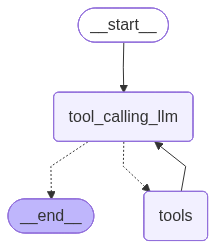

In [36]:
from IPython.display import Image, display
## visualize graph as mermaid diagram
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
graph_result = graph.invoke({"messages":HumanMessage(content= "What is machine learning?")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wiki_search (dfeh1dry8)
 Call ID: dfeh1dry8
  Args:
    query: machine learning definition
================================= Tool Message =================================
Name: wiki_search

Wikipedia search results for 'machine learning definition': Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline
================================== Ai Message ==================================
Tool Calls:
  wiki_search (55aevq2pp)
 Call ID: 55aevq2pp
  Args:
    query: machine learning subdisciplines
================================= Tool Message ========

In [42]:
graph_result = graph.invoke({"messages":HumanMessage(content= "1706.03762?")}) 

for message in graph_result['messages']:
    message.pretty_print()

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'wikipedia_search' which was not in request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=wikipedia_search>{"query": "Jakob Uszkoreit"}</function>'}}

In [ ]:
graph_result = graph.invoke({"messages":HumanMessage(content= "Provide me to 3 recent AI news as on today")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

Provide me to 3 recent AI news as on today
================================== Ai Message ==================================
Tool Calls:
  arxiv_search (0ctwjzcpm)
 Call ID: 0ctwjzcpm
  Args:
    query: Recent advances in AI
  wiki_search (x4e9tctne)
 Call ID: x4e9tctne
  Args:
    query: Recent AI news
  tavily_search (c028yjttx)
 Call ID: c028yjttx
  Args:
    query: Recent AI news updates
================================= Tool Message =================================
Name: arxiv_search

Arxiv search results for 'Recent advances in AI': Published: 2025-01-15
Title: Trustworthy, Responsible, and Safe AI: A Comprehensive Architectural Framework for AI Safety with Challenges and Mitigations
Authors: Chen Chen, Xueluan Gong, Ziyao Liu, Weifeng Jiang, Si Qi Goh, Kwok-Yan Lam
Summary: AI Safety is an emerging area of critical importance 
================================= Tool Message =========================

In [ ]:
graph_result = graph.invoke({"messages":HumanMessage(content= "What is 2+7?")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2+7?
================================== Ai Message ==================================
Tool Calls:
  add (8f1c6rwtd)
 Call ID: 8f1c6rwtd
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: add

9


In [ ]:
graph_result = graph.invoke({"messages":HumanMessage(content= "What is 2 * 7?")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

What is 2 * 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (0v7nam0xh)
 Call ID: 0v7nam0xh
  Args:
    a: 2
    b: 7
================================= Tool Message =================================
Name: multiply

14.0


In [ ]:
graph_result = graph.invoke({"messages":HumanMessage(content= "Who is Shahrukh khan?")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

Who is Shahrukh khan?
================================== Ai Message ==================================
Tool Calls:
  wiki_search (p95jrr6e4)
 Call ID: p95jrr6e4
  Args:
    query: Shahrukh Khan
================================= Tool Message =================================
Name: wiki_search

Wikipedia search results for 'Shahrukh Khan': Page: Shah Rukh Khan
Summary: Shahrukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), and popularly known by the initials SRK, is an Indian actor and film producer renowned for his work in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appear


In [ ]:
graph_result = graph.invoke({"messages":HumanMessage(content= "add 5 + 2 and then multiply result of addition by 10")}) 

for message in graph_result['messages']:
    message.pretty_print()# react agent architecture query with multiple tools. act,observe and reason. tool output response comes back to llm for final answer

================================ Human Message =================================

add 5 + 2 and then multiply result of addition by 10
================================== Ai Message ==================================
Tool Calls:
  add (trn5t4vkm)
 Call ID: trn5t4vkm
  Args:
    a: 5
    b: 2
  multiply (8ax3xgtfm)
 Call ID: 8ax3xgtfm
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

70.0


In [41]:
graph_result = graph.invoke({"messages":HumanMessage(content= "divide that by 5")}) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

divide that by 5
================================== Ai Message ==================================

I don't have enough information to perform the operation. What numbers would you like me to divide by 5?


In [43]:
# agent memory with multiple tool calls and llm reasoning can be built further
# memory saver - checkpointer to automatically save and load graph state from disk or db
# thread - collection of checkpoints
from langgraph.checkpoint.memory import MemorySaver #, Thread
memory = MemorySaver()
#thread = Thread(name="chatbot_with_multiple_tools_thread", memory_saver=memory)
config = {"configurable":{"thread_id":"1"}}
graph_memory = graph_builder.compile(checkpointer=memory)

In [44]:
graph_result = graph_memory.invoke({"messages":HumanMessage(content= "add 5 + 2 and then multiply result of addition by 10")},config=config) 

for message in graph_result['messages']:
    message.pretty_print()# react agent architecture query with multiple tools. act,observe and reason. tool output response comes back to llm for final answer

================================ Human Message =================================

add 5 + 2 and then multiply result of addition by 10
================================== Ai Message ==================================
Tool Calls:
  add (rgvztxb1e)
 Call ID: rgvztxb1e
  Args:
    a: 5
    b: 2
  multiply (y35dq95we)
 Call ID: y35dq95we
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

70.0
================================== Ai Message ==================================

The result of the addition is 7 and the result of the multiplication is 70.


In [45]:
graph_result = graph_memory.invoke({"messages":HumanMessage(content= "divide that by 5")},config=config) 

for message in graph_result['messages']:
    message.pretty_print()

================================ Human Message =================================

add 5 + 2 and then multiply result of addition by 10
================================== Ai Message ==================================
Tool Calls:
  add (rgvztxb1e)
 Call ID: rgvztxb1e
  Args:
    a: 5
    b: 2
  multiply (y35dq95we)
 Call ID: y35dq95we
  Args:
    a: 7
    b: 10
================================= Tool Message =================================
Name: add

7
================================= Tool Message =================================
Name: multiply

70.0
================================== Ai Message ==================================

The result of the addition is 7 and the result of the multiplication is 70.
================================ Human Message =================================

divide that by 5
================================== Ai Message ==================================
Tool Calls:
  Divide (ycgyje8rq)
 Call ID: ycgyje8rq
  Args:
    a: 70
    b: 5
========================